In [1]:
!python -V

Python 3.8.15


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

## Q1. Downloading the data
Read the data for January. How many columns are there?

In [7]:
number_columns = df.shape[1]
column_names = pd.DataFrame(df.columns.values, columns=["names"])
print(f"Number of colums: {number_columns}")
display(column_names)

Number of colums: 19


,names
0,VendorID
1,tpep_pickup_datetime
2,tpep_dropoff_datetime
3,passenger_count
4,trip_distance
5,RatecodeID
6,store_and_fwd_flag
7,PULocationID
8,DOLocationID
9,payment_type


## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the standard deviation of the trips duration in January?

In [8]:
df['duration'] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.seconds/60
std_duration = df["duration"].std()
print(f"The std duration of trips in January is {round(std_duration,2)}")

The std duration of trips in January is 41.63


## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [9]:
condition =  (df['duration']>=1) & (df['duration']<=60)
prop = round(condition.mean(),2)
print(f"Fraction of records without outliers: {prop}")

df = df[condition].reset_index()

Fraction of records without outliers: 0.98


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will 
  label encode them)
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [10]:
categorical = ['PULocationID', 'DOLocationID']
#numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [11]:
train_dicts = df[categorical].to_dict(orient='records')

In [12]:
uniquePULocationID = df["PULocationID"].unique().tolist()
uniqueDOLocationID = df["DOLocationID"].unique().tolist()
expected_size = len(uniquePULocationID) + len(uniqueDOLocationID)
print(f"The expected size is {expected_size}")

The expected size is 515


In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [14]:
size = X_train.shape[1]
print(f"The feature vector size is {size}")

The feature vector size is 515


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [15]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [16]:
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"The MSE: {round(rmse, 2)}")

The MSE: 7.65


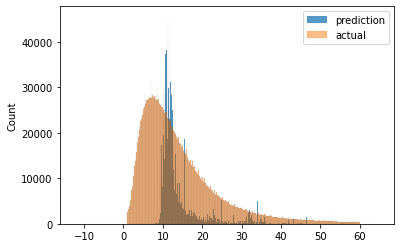

In [21]:
sns.histplot(y_pred, label='prediction', color="tab:blue")
sns.histplot(y_train, label='actual', color="tab:orange", alpha=0.5)

plt.legend()

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023). 

What's the RMSE on validation?

In [28]:
def get_features(file_name, categorical, target, dv=None):
    df_raw = pd.read_parquet(file_name)
    df_raw['duration'] = (df_raw["tpep_dropoff_datetime"] - df_raw["tpep_pickup_datetime"]).dt.seconds/60

    condition =  (df_raw['duration']>=1) & (df_raw['duration']<=60)
    df = df_raw[condition].reset_index()
    #numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    x_dicts = df[categorical].to_dict(orient='records')
    if dv==None:
        dv = DictVectorizer()
        X_matrix = dv.fit_transform(x_dicts)
    else:
        X_matrix = dv.transform(x_dicts)

    y = df[target].values

    return X_matrix, y, dv

In [32]:
train_file_name = "./data/yellow_tripdata_2023-01.parquet"
test_file_name = "./data/yellow_tripdata_2023-02.parquet"

categorical = ['PULocationID', 'DOLocationID']
target = 'duration'


X_train, y_train, dv = get_features(train_file_name, categorical, target, dv=None)
X_test, y_test, _ = get_features(test_file_name, categorical, target, dv)

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [34]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Training MSE: {round(rmse_train, 2)}")
print(f"Test MSE: {round(rmse_test, 2)}")

Training MSE: 7.65
Test MSE: 7.81
